In [16]:
import os
import sys
import json
import pickle

from embedding import BertHuggingface

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

import functools

import numpy as np
import math
import random
import scipy

import plotting
import utils
import yaml

In [17]:
CONFIG_FILE = 'configs/new/experiment_config.json'
EMB_SIZE_LOOKUP = {'text-embedding-3-small': 1536,
                   'text-embedding-3-large': 3072,
                   'google/electra-base-generator': 256,
                   'albert-base-v2': 768,
                   'distilbert-base-uncased': 768,
                   'gpt2': 768,
                   'bert-base-uncased': 768,
                   'roberta-base': 768,
                   'bert-large-uncased': 1024,
                   'roberta-large': 1024,
                   'gpt2-large': 1280,
                   'google/electra-base-discriminator': 768
                  }

## Setup

In [18]:
with open(CONFIG_FILE, 'r') as f:
    config = json.load(f)

openai_models = config["openai_models"]
huggingface_models = config["huggingface_models"]
models = huggingface_models + openai_models

In [19]:
results_cav = pd.read_csv('../'+config['results_dir']+config['cav_results_file'])
results_cbm = pd.read_csv('../'+config['results_dir']+config['cbm_results_file'])
results_bias_space = pd.read_csv('../'+config['results_dir']+config['bias_space_results_file'])

In [20]:
assert (results_cav.columns == results_cbm.columns).all() and (results_cav.columns == results_bias_space.columns).all()

In [21]:
results_cav

,protected_attr,dataset (train),dataset (eval),embedder,pooling,group (test),concept (train),F1,Pearson R,Pearson p
0,disability,jigsaw,jigsaw,bert-base-uncased,mean,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.498327,0.006580,3.639204e-01
1,disability,jigsaw,crows_pairs,bert-base-uncased,mean,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.497248,0.042390,3.275389e-01
2,disability,crows_pairs,jigsaw,bert-base-uncased,mean,mental_disability_illness,mental_disability_illness,0.503554,0.120211,2.197847e-54
3,disability,jigsaw,jigsaw,bert-base-uncased,cls,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.498327,0.033130,4.816299e-06
4,disability,jigsaw,crows_pairs,bert-base-uncased,cls,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.497248,0.007367,4.912210e-01
...,...,...,...,...,...,...,...,...,...,...
678,gender,crows_pairs,stereoset,gpt2-large,cls,female vs. rest,female vs. rest,0.268054,0.210908,1.307413e-24
679,gender,crows_pairs,stereoset,gpt2-large,cls,male,male,0.268054,0.224211,8.348911e-31
680,gender,crows_pairs,stereoset,gpt2-large,cls,female,female,0.268054,0.216580,3.447349e-26
681,gender,stereoset,bios-supervised,gpt2-large,cls,male,male,0.118223,0.272064,4.261307e-34


In [22]:
results_cbm

,protected_attr,dataset (train),dataset (eval),embedder,pooling,group (test),concept (train),F1,Pearson R,Pearson p
0,disability,jigsaw,jigsaw,bert-base-uncased,mean,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.004496,NaN,NaN
1,disability,jigsaw,crows_pairs,bert-base-uncased,mean,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.004616,NaN,NaN
2,disability,jigsaw,jigsaw,bert-base-uncased,cls,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.002880,NaN,NaN
3,disability,jigsaw,crows_pairs,bert-base-uncased,cls,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.001983,NaN,NaN
4,disability,jigsaw,jigsaw,bert-large-uncased,mean,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.004548,NaN,NaN
5,disability,jigsaw,crows_pairs,bert-large-uncased,mean,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.005599,NaN,NaN
6,disability,jigsaw,jigsaw,bert-large-uncased,cls,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.003663,NaN,NaN
7,disability,jigsaw,crows_pairs,bert-large-uncased,cls,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.001983,NaN,NaN
8,gender,bios-supervised,bios-supervised,bert-base-uncased,mean,male,male,0.995126,0.93510,0.0
9,gender,bios-supervised,bios-supervised,bert-base-uncased,mean,female,female,0.995126,0.93511,0.0


In [23]:
results_bias_space

,protected_attr,dataset (train),dataset (eval),embedder,pooling,group (test),concept (train),F1,Pearson R,Pearson p
0,gender,/,bios-supervised,bert-base-uncased,mean,male,male,0,0.872673,0.000000e+00
1,gender,/,bios-supervised,bert-base-uncased,mean,female,female,0,0.872673,0.000000e+00
2,gender,/,jigsaw,bert-base-uncased,mean,any,any,0,0.270662,5.993837e-317
3,gender,/,jigsaw,bert-base-uncased,mean,male vs. rest,male,0,0.210626,6.688814e-190
4,gender,/,jigsaw,bert-base-uncased,mean,female vs. rest,female,0,0.210626,6.688814e-190
...,...,...,...,...,...,...,...,...,...,...
913,race,/,stereoset,distilgpt2,mean,middle east,middle eastern,0,-0.028747,1.202533e-03
914,race,/,twitterAAE,distilgpt2,cls,aa,black,0,0.053349,6.076670e-64
915,race,/,twitterAAE,distilgpt2,cls,white,white,0,0.082333,6.147159e-150
916,race,/,jigsaw,distilgpt2,cls,any,any,0,-0.020857,3.999120e-03


## Process results

In [24]:
# set concept method
res_bias_space = results_bias_space.copy()
res_bias_space['method'] = 'bias space'
res_cav = results_cav.copy()
res_cav['method'] = 'CAV'
res_cbm = results_cbm.copy()
res_cbm['method'] = 'CBM'

# merge results
res_all = pd.concat([res_bias_space, res_cav, res_cbm])
res_all = res_all.reset_index()

# fill empty pooling cells (openai models)
res_all.loc[:,'pooling'] = res_all.loc[:,'pooling'].fillna('unknown')

In [25]:
def get_pretrained_model(model_name, n_classes, batch_size=1, pooling='mean', multi_label=False):    
    if multi_label: 
        lm = BertHuggingface(n_classes, model_name=model_name, batch_size=batch_size, pooling=pooling, loss_function=torch.nn.BCEWithLogitsLoss)
    else:
        lm = BertHuggingface(n_classes, model_name=model_name, batch_size=batch_size, pooling=pooling)
    return lm

def get_model_architecture(model_name):
    if type(model_name) != str:
        return model_name
        
    if model_name in openai_models:
        return 'embedder' # presumably also encoder based
    if 'gpt' in model_name:
        return 'decoder'
    else:
        return 'encoder'

def get_model_type(model_name):
    if type(model_name) != str:
        return model_name
        
    if model_name in openai_models:
        return 'embedder'
    if 'gpt' in model_name or 'generator' in model_name:
        return 'generator'
    else:
        return 'discriminator'

res_all['model_type'] = [get_model_type(res_all.loc[i,'embedder']) for i in range(len(res_all))]
res_all['model_architecture'] = [get_model_architecture(res_all.loc[i,'embedder']) for i in range(len(res_all))]

def get_emb_size(model_name):
    # check model's emb size is saved in the lookup
    if not model_name in EMB_SIZE_LOOKUP.keys():
        if model_name in huggingface_models:
            # load model and get size
            lm = get_pretrained_model(model_name, 2, batch_size=1)
            EMB_SIZE_LOOKUP[model_name] = lm.model.config.hidden_size
        else:
            print("cannot query model size for %s, which is not in the list of huggingface models (set size to 0)")
            EMB_SIZE_LOOKUP[model_name] = 0

    return EMB_SIZE_LOOKUP[model_name]

res_all['emb_size'] = [get_emb_size(res_all.loc[i,'embedder']) for i in range(len(res_all))]
res_all

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/saschroeder/anaconda3/envs/presecolm/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


manually define padding token for model distilgpt2
Using Bert with CUDA/GPU
no optmizer specified, default to AdamW
no loss function specified, default to cross entropy


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU
no optmizer specified, default to AdamW
no loss function specified, default to cross entropy


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-large-generator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU
no optmizer specified, default to AdamW
no loss function specified, default to cross entropy


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-large-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-large-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU
no optmizer specified, default to AdamW
no loss function specified, default to cross entropy
Using Bert with CUDA/GPU
no optmizer specified, default to AdamW
no loss function specified, default to cross entropy


Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-160m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


manually define padding token for model EleutherAI/pythia-160m
Using Bert with CUDA/GPU
no optmizer specified, default to AdamW
no loss function specified, default to cross entropy
cannot query model size for %s, which is not in the list of huggingface models (set size to 0)


,index,protected_attr,dataset (train),dataset (eval),embedder,pooling,group (test),concept (train),F1,Pearson R,Pearson p,method,model_type,model_architecture,emb_size
0,0,gender,/,bios-supervised,bert-base-uncased,mean,male,male,0.000000,0.872673,0.000000e+00,bias space,discriminator,encoder,768
1,1,gender,/,bios-supervised,bert-base-uncased,mean,female,female,0.000000,0.872673,0.000000e+00,bias space,discriminator,encoder,768
2,2,gender,/,jigsaw,bert-base-uncased,mean,any,any,0.000000,0.270662,5.993837e-317,bias space,discriminator,encoder,768
3,3,gender,/,jigsaw,bert-base-uncased,mean,male vs. rest,male,0.000000,0.210626,6.688814e-190,bias space,discriminator,encoder,768
4,4,gender,/,jigsaw,bert-base-uncased,mean,female vs. rest,female,0.000000,0.210626,6.688814e-190,bias space,discriminator,encoder,768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,5,disability,jigsaw,crows_pairs,bert-large-uncased,mean,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.005599,NaN,NaN,CBM,discriminator,encoder,1024
1607,6,disability,jigsaw,jigsaw,bert-large-uncased,cls,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.003663,NaN,NaN,CBM,discriminator,encoder,1024
1608,7,disability,jigsaw,crows_pairs,bert-large-uncased,cls,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.001983,NaN,NaN,CBM,discriminator,encoder,1024
1609,8,gender,bios-supervised,bios-supervised,bert-base-uncased,mean,male,male,0.995126,0.935100,0.000000e+00,CBM,discriminator,encoder,768


In [26]:
# from a western-centric perspective (leaving white,male,christian as non-marginalized groups)
marginalized_groups = ['F', 'female', 'asian', 'black', 'latino', 'buddhist', 'hindu', 'jewish', 'muslim', 'mental_disability_illness', 'psychiatric_or_mental_illness']

# from a western/ US perspective / groups that appear infrequent in the datasets (TODO confirm and provide than threshold)
minority_groups = ['asian', 'latino', 'buddhist', 'hindu', 'mental_disability_illness', 'psychiatric_or_mental_illness']


## Utils

In [27]:
def aggregate_results(results, sel_cols, target_col):
    grouped_res = results.groupby(sel_cols, as_index=False)[target_col].mean().reset_index()
    grouped_res[target_col+' var'] = results.groupby(sel_cols, as_index=False)[target_col].var()[target_col]
    return grouped_res

In [38]:
def boxplot(results, ax, xcol, ycol, huecol, title, remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0):
    # mark 0 with hline
    ax.hlines(y=0, xmin=-1, xmax=6, linewidth=0.5, color='black')

    # do boxplot
    if huecol is not None:
        sns.boxplot(data=results, x=xcol, y=ycol, hue=huecol, ax=ax)
    else:
        sns.boxplot(data=res_dataset, x=xcol, y=ycol, ax=ax)

    # set title and labels/ change fontsize
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('')
    if add_ylabel:
        ax.set_ylabel(ycol, fontsize=15)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=15)
    
    # set lenged if required, set ylim to make space for legend
    ax.set_ylim(ymin, ymax)
    legend = ax.legend(fontsize=14)
    if remove_legend:
        legend.remove()

def multipot(results, subplot_col, xcol, ycol, huecol, title=None, remove_legend=False, savefile=None):
    # create a subplot for unique value in subplot_col
    subplot_choices = list(set(results.loc[:,subplot_col]))
    fig, axes = plt.subplots(1, len(subplot_choices), figsize=(5*len(subplot_choices), 4))

    # do boxplot for each value in subplot_col
    if len(subplot_choices) == 1:
        boxplot(results, axes, xcol=xcol, ycol=ycol, huecol=huecol, title=subplot_choices[0], add_ylabel=True)
    else:
        for i, val in enumerate(subplot_choices):
            res_filt = results.loc[results[subplot_col] == val]
            boxplot(res_filt, axes[i], xcol=xcol, ycol=ycol, huecol=huecol, title=val, add_ylabel=(i==0))
    if title is not None:
        plt.suptitle(title)
    
    # (save and) show figure
    if savefile is not None:
        if '.eps' in savefile:
            plt.savefig(savefile, format='eps', bbox_inches='tight')
        else:
            plt.savefig(savefile, bbox_inches='tight')
    plt.show()

## 1) Baseline: Linear Concept learning (CAV, CBM)

Report and plot F1-scores for CAV and CBM in the regular concept learning (train-test from same datasets) and concept transfer (to another dataset) setting. The concept learning serves as a baseline as it should reflect the best possible estimation of linear concepts in the language model's embeddings (assuming classifiers converge; given the available data). The concept transfer case shows how robust or dataset-specific the learned concepts are.

### a) Learning and testing on splits of the same dataset

In [29]:
res_cl = res_all[res_all['method'] != 'bias space']

# aggregate results of all groups of the same experiment run
gres = aggregate_results(res_cl, ['method', 'protected_attr', 'dataset (train)', 'dataset (eval)', 'pooling', 'embedder'], 'F1')

# add column to distinguish transfer and non-transfer cases
gres.loc[:, 'exp'] = ['transfer' if gres.loc[i, 'dataset (train)'] != gres.loc[i, 'dataset (eval)'] else '' for i in range(len(gres))]
gres_same_dataset = gres[gres['exp'] != 'transfer']

# summarize results per dataset and transfer/ non transfer
res_per_dataset_transfer = aggregate_results(gres_same_dataset, ['exp', 'dataset (eval)', 'method'], 'F1')
res_per_dataset_transfer

,index,exp,dataset (eval),method,F1,F1 var
0,0,,bios-supervised,CAV,0.697755,1.109690e-02
1,1,,bios-supervised,CBM,0.995126,NaN
2,2,,crows_pairs,CAV,0.884552,6.539727e-03
3,3,,jigsaw,CAV,0.454903,4.483747e-02
4,4,,jigsaw,CBM,0.003897,6.239591e-07
5,5,,stereoset,CAV,0.604141,9.739675e-03


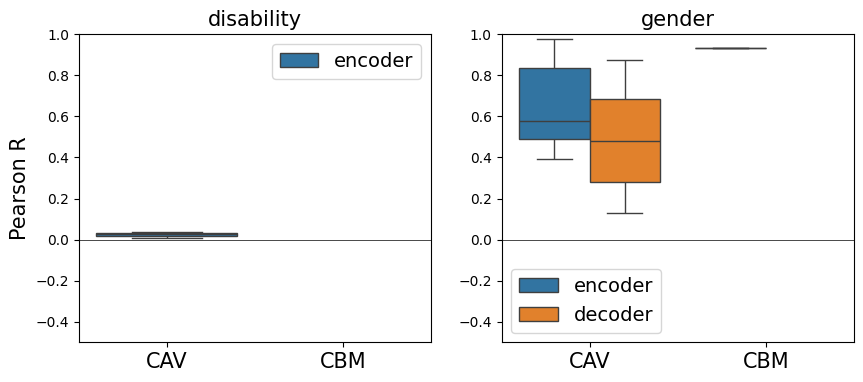

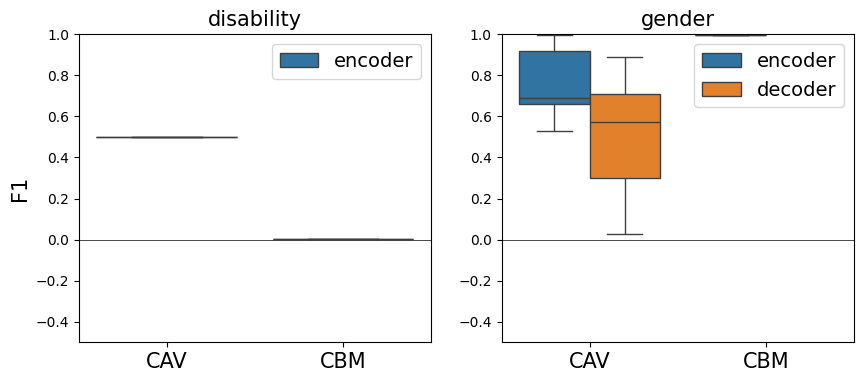

In [30]:
res_cl_same_dataset = res_cl[res_cl['dataset (train)'] == res_cl['dataset (eval)']]

multipot(res_cl_same_dataset, subplot_col='protected_attr', xcol='method', ycol='Pearson R', huecol='model_architecture', remove_legend=False)
multipot(res_cl_same_dataset, subplot_col='protected_attr', xcol='method', ycol='F1', huecol='model_architecture', remove_legend=False)

### b) Cross-dataset transfer

In [31]:
gres_transfer = gres[gres['exp'] == 'transfer']

# summarize results per dataset and transfer/ non transfer
res_per_dataset_transfer = aggregate_results(gres_transfer, ['exp', 'dataset (eval)', 'method'], 'F1')
res_per_dataset_transfer

,index,exp,dataset (eval),method,F1,F1 var
0,0,transfer,bios-supervised,CAV,0.421163,0.088879
1,1,transfer,crows_pairs,CAV,0.429459,0.022005
2,2,transfer,crows_pairs,CBM,0.003545,0.000003
3,3,transfer,jigsaw,CAV,0.252827,0.019702
4,4,transfer,stereoset,CAV,0.253050,0.019898


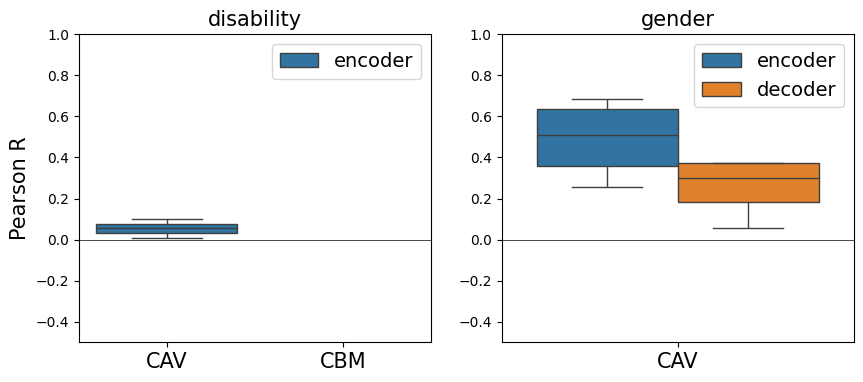

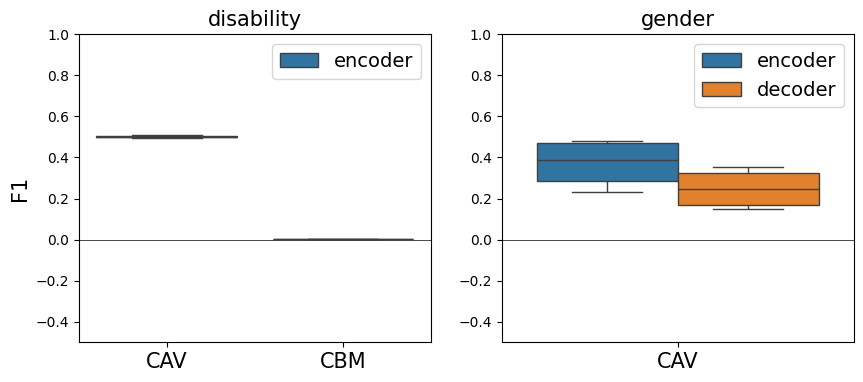

In [32]:
res_cl_transfer = res_cl[res_cl['dataset (train)'] != res_cl['dataset (eval)']]

# aggregate results over dataset first (bc number of rows/ protected groups is different!)
grouped_res_r = res_cl_transfer.groupby(['protected_attr', 'dataset (eval)', 'method', 'model_type','model_architecture'], as_index=False)['Pearson R'].mean().reset_index()
multipot(grouped_res_r, subplot_col='protected_attr', xcol='method', ycol='Pearson R', huecol='model_architecture', remove_legend=False)

grouped_res_f1 = res_cl_transfer.groupby(['protected_attr', 'dataset (eval)', 'method', 'model_type','model_architecture'], as_index=False)['F1'].mean().reset_index()
multipot(grouped_res_f1, subplot_col='protected_attr', xcol='method', ycol='F1', huecol='model_architecture', remove_legend=False)

## 2) Evaluating Bias Space for Concept Retrieval

Comparing Pearson Correlation of Bias Space concepts with CBM and CAV.

### a) Overview over protected attributes.

In [33]:
res_all.columns

Index(['index', 'protected_attr', 'dataset (train)', 'dataset (eval)',
       'embedder', 'pooling', 'group (test)', 'concept (train)', 'F1',
       'Pearson R', 'Pearson p', 'method', 'model_type', 'model_architecture',
       'emb_size'],
      dtype='object')

In [34]:
# aggregate results over groups of the same experiment setup
gres = aggregate_results(res_all, ['protected_attr', 'dataset (train)', 'dataset (eval)', 'embedder', 'pooling', 'method', 'model_architecture', 'model_type', 'emb_size'], 'Pearson R')

In [35]:
gres_same_dataset = gres[(gres['method'] == 'bias space') | (gres['dataset (train)'] == gres['dataset (eval)'])]
gres_transfer = gres[(gres['method'] == 'bias space') | (gres['dataset (train)'] != gres['dataset (eval)'])]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


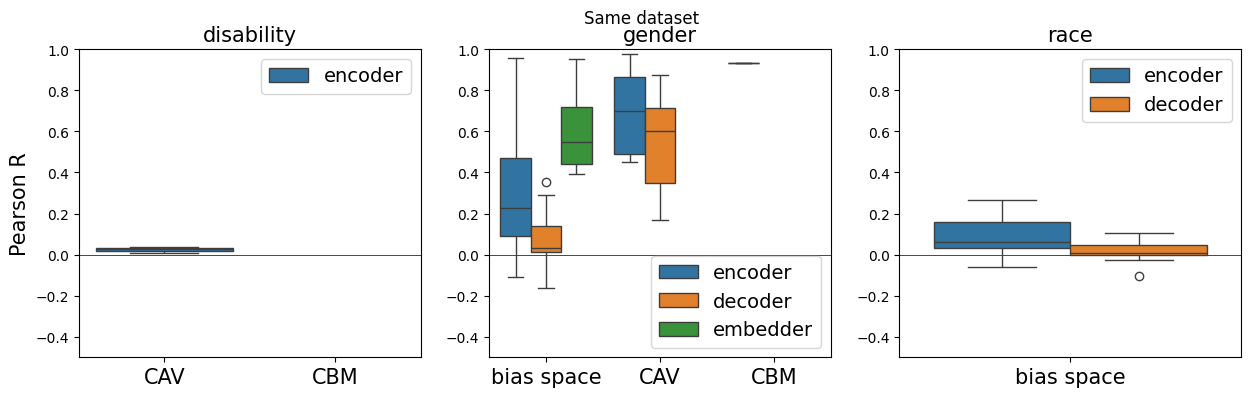

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


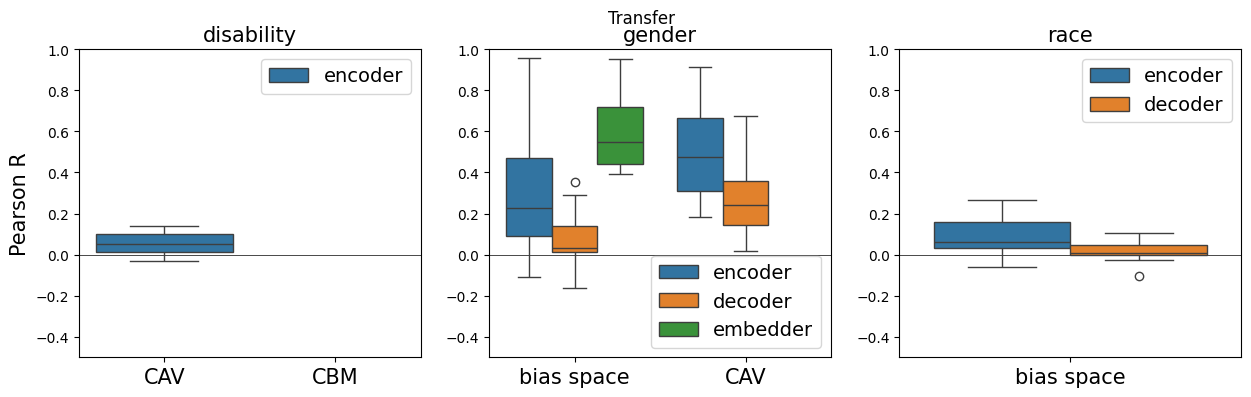

In [39]:
multipot(gres_same_dataset, subplot_col='protected_attr', xcol='method', ycol='Pearson R', huecol='model_architecture', title='Same dataset', remove_legend=False, savefile='plots/esann25/corr.eps')
multipot(gres_transfer, subplot_col='protected_attr', xcol='method', ycol='Pearson R', huecol='model_architecture', title='Transfer', remove_legend=False, savefile='plots/esann25/corr.eps')

### b) Overview over datasets (one plot per attribute)


gender


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


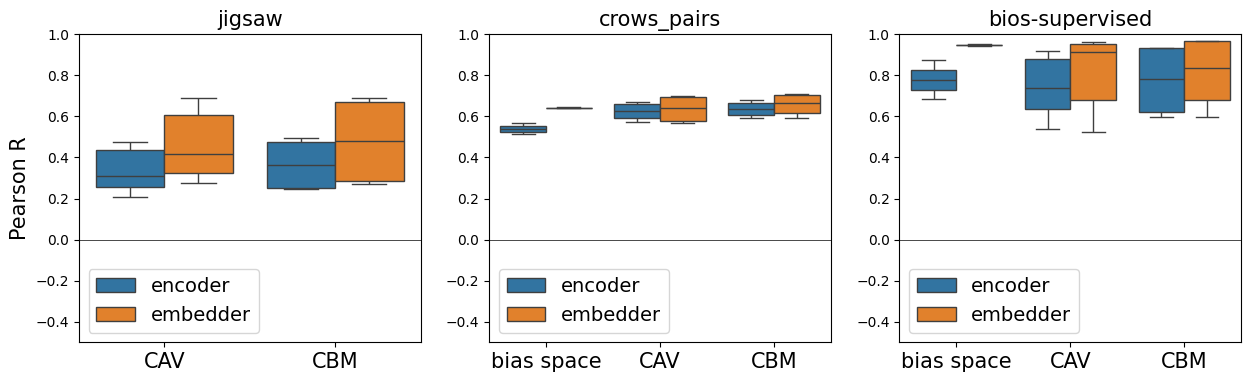


race


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


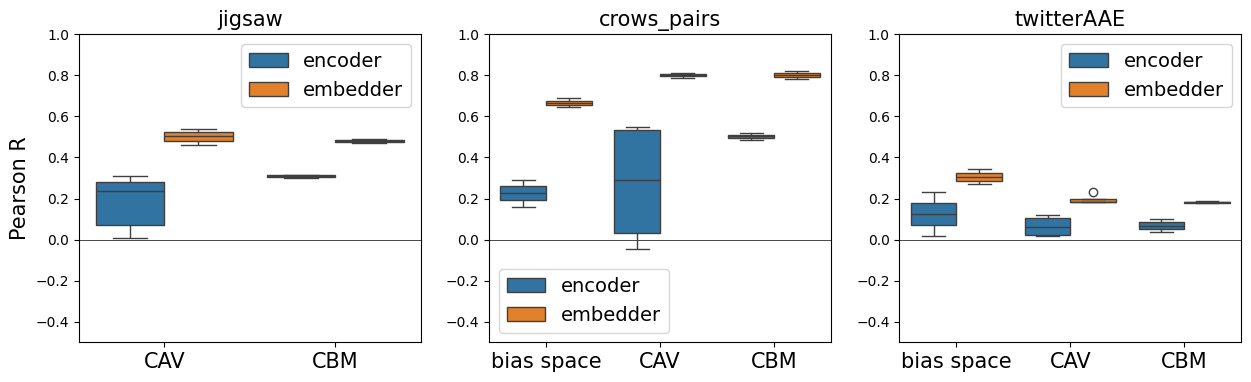

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



religion


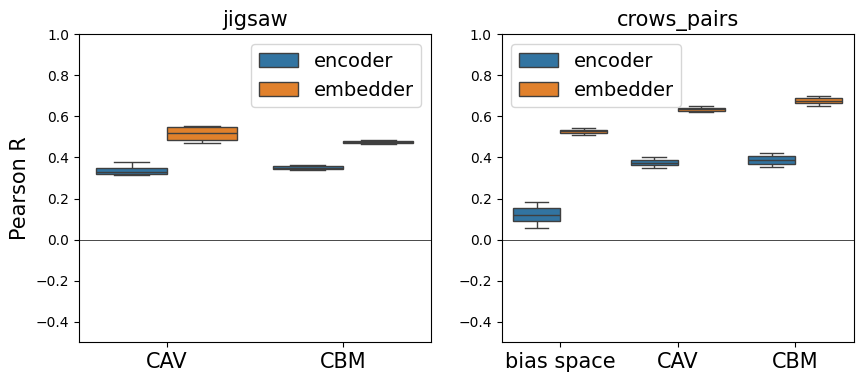

In [37]:
protected_attr = list(set(gres['protected_attr']))
for attr in protected_attr:
    print()
    print(attr)
    res_filt = gres[gres['protected_attr'] == attr]
    multipot(res_filt, subplot_col='dataset (eval)', xcol='method', ycol='Pearson R', huecol='model_architecture', remove_legend=False, savefile=('plots/esann25/corr_%s.eps' % attr))